# INTRODUCTORY OVERVIEW OF PYMC

## LOAD LIBRARIES

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import arviz as az
import pymc as pm
import pytensor.tensor as at

## Generating data

In [4]:
%config InlineBackend.figure_format = 'retina'

In [5]:
# Initialize random number generator
seed = 8927
rng = np.random.default_rng(seed)
az.style.use('arviz-darkgrid')

In [6]:
# True parameters value
alpha, sigma = 1, 1
beta = [1, 2.5]

In [7]:
# Size of dataset
size = 100

In [8]:
# Predictors
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

In [9]:
# Simulate outcome varible
Y = alpha + beta[0] * X1 + beta[1] * X2 + rng.normal(size = size) * sigma

Text(0.5, 0, 'X2')

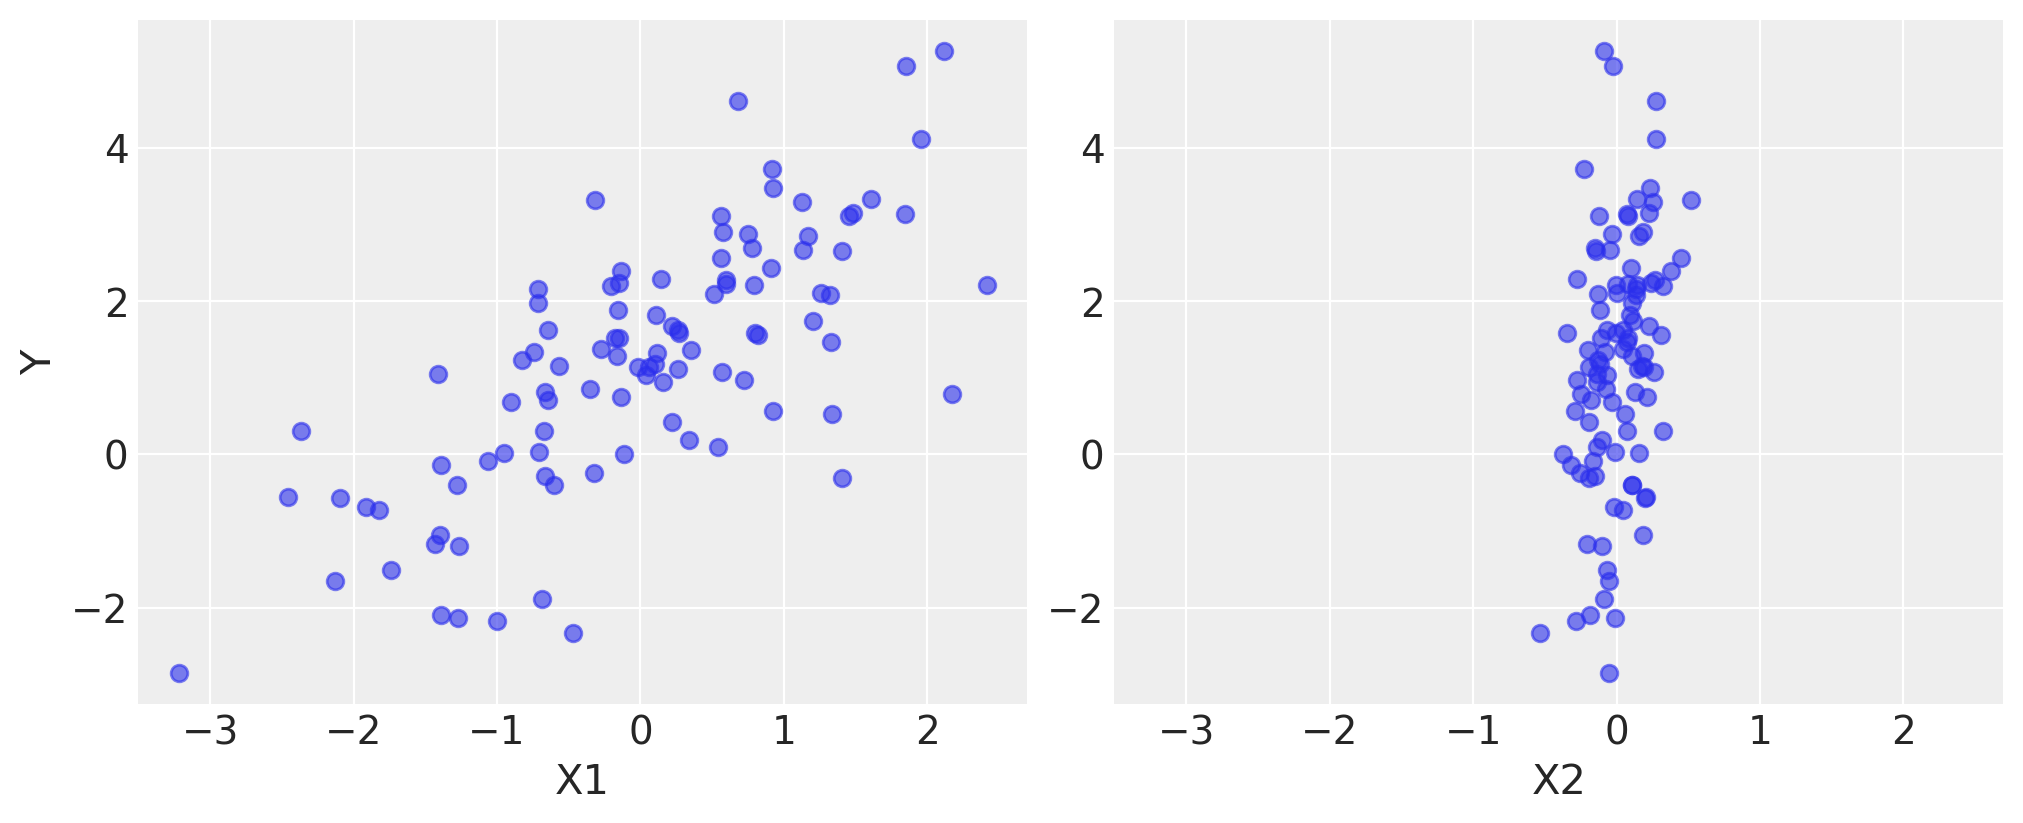

In [10]:
# Plot
fig, axes = plt.subplots(1, 2, sharex = True, figsize=(10,4))
axes[0].scatter(X1, Y, alpha=0.6)
axes[1].scatter(X2, Y, alpha=0.6)
axes[0].set_ylabel("Y")
axes[0].set_xlabel("X1")
axes[1].set_xlabel("X2")

## Model specification

In [11]:
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.7.1


In [12]:
basicModel = pm.Model()

In [13]:
with basicModel:
    # Priors for unknow model parameters
    alpha = pm.Normal('alpha', mu = 0, sigma = 10)
    beta = pm.Normal('beta', mu = 0, sigma = 10, shape = 2)
    sigma = pm.HalfNormal('sigma', sigma = 1)

    # Model formula
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelyhood
    Y_obs = pm.Normal('Y_obs', mu = mu, sigma = sigma, observed = Y)

## Chains execution

In [14]:
with basicModel:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 185 seconds.


In [15]:
idata.posterior['alpha'].sel(draw = slice(0, 4))

<xarray.DataArray 'alpha' (chain: 4, draw: 5)>
array([[1.15737653, 1.13046991, 1.21766088, 1.02937444, 1.29102866],
       [1.22324237, 0.98633183, 1.04705861, 1.08328247, 1.11890517],
       [1.03791866, 1.21140781, 1.2831223 , 1.22505038, 0.98980645],
       [1.23888   , 1.06857898, 1.26160582, 1.04760465, 1.13662992]])
Coordinates:
  * chain    (chain) int32 0 1 2 3
  * draw     (draw) int32 0 1 2 3 4

In [16]:
# Slice sampling instead od Nuts
with basicModel:
    # Initialize sampler
    step = pm.Slice()

    # Draw 5000 posterior samples
    slice_data = pm.sample(5000, step = step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [alpha]
>Slice: [beta]
>Slice: [sigma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 1076 seconds.


## Posterior analysis

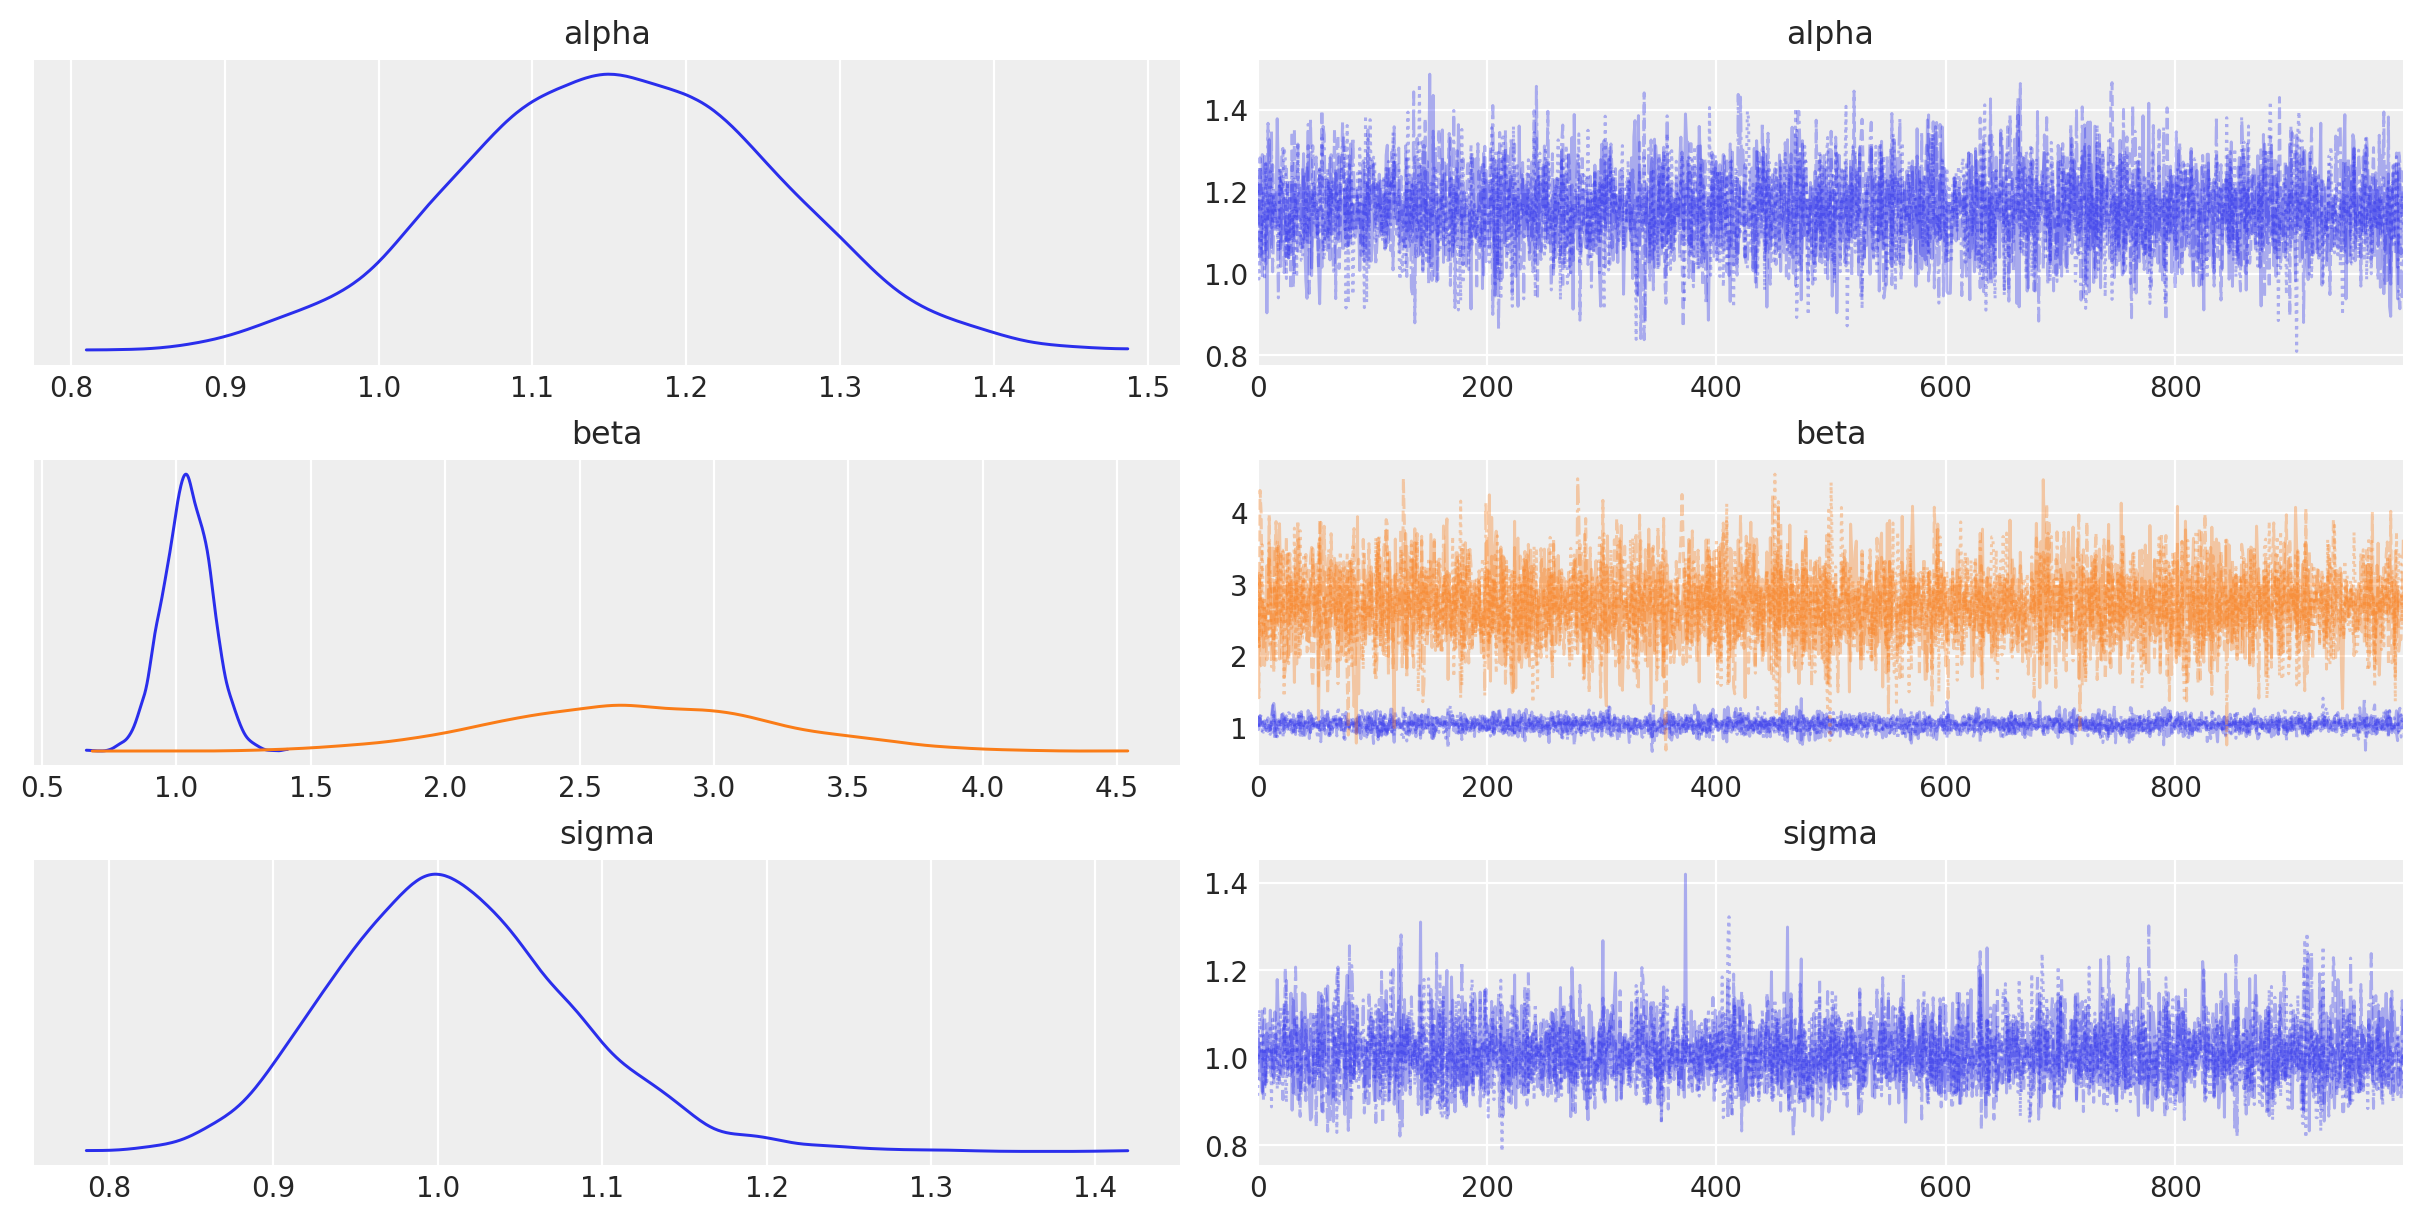

In [17]:
az.plot_trace(idata, combined = True);

In [18]:
az.summary(idata, round_to = 2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha    1.16  0.10    0.96     1.34       0.00      0.0   5908.59   3264.60   
beta[0]  1.04  0.09    0.87     1.21       0.00      0.0   5471.29   3094.14   
beta[1]  2.71  0.53    1.72     3.69       0.01      0.0   6216.56   3210.32   
sigma    1.01  0.07    0.89     1.15       0.00      0.0   5894.71   3358.59   

         r_hat  
alpha      1.0  
beta[0]    1.0  
beta[1]    1.0  
sigma      1.0

## CASE STUDY 01 

### Load data


In [19]:
testScores = pd.read_csv(pm.get_data('test_scores.csv'), index_col = 0)
testScores.head()

score  male  siblings  family_inv  non_english  prev_disab  age_test  \
0     40     0       2.0         2.0        False         NaN        55   
1     31     1       0.0         NaN        False         0.0        53   
2     83     1       1.0         1.0         True         0.0        52   
3     75     0       3.0         NaN        False         0.0        55   
5     62     0       0.0         4.0        False         1.0        50   

   non_severe_hl  mother_hs  early_ident  non_white  
0            1.0        NaN        False      False  
1            0.0        0.0        False      False  
2            1.0        NaN        False       True  
3            0.0        1.0        False      False  
5            0.0        NaN        False      False

In [20]:
# Drop missing
X = testScores.dropna().astype(float)
y = X.pop('score') 

In [21]:
# Standardize features
X -= X.mean()
X /= X.std()

In [22]:
# Get dimensions
N, D = X.shape

### Horeshoe regularization

In [23]:
# Total of real parameters for global shrinkage
D0 = int(D/2)

### Model specification

In [26]:
with pm.Model(coords = {'predictors': X.columns.values}) as testScoreMds:
    # Prior on error SD
    sigma = pm.HalfNormal('sigma', 25)
    
    # Global shrinkage 
    tau = pm.HalfStudentT('tau', 2, D0/(D-D0)*sigma/np.sqrt(N))
    
    # Local shrinkage
    lam = pm.HalfStudentT('lam', 2, dims = 'predictors')
    c2 = pm.InverseGamma('c2', 1, 0.1)
    z = pm.Normal('z', 0.0, 1.0, dims = 'predictors')
    
    # Shrunken coefficients
    beta = pm.Deterministic(
        'beta', z * tau * lam * at.sqrt(c2 / (c2 + tau**2 * lam**2)), dims = 'predictors'
    )
    
    # Intercept (not shrunken)
    beta0 = pm.Normal('beta0', 100, 25.0)
    
    # Likelyhood
    
    scores = pm.Normal('scores', beta0 + at.dot(X.values, beta), sigma, observed = y.values)

### Plot model structure

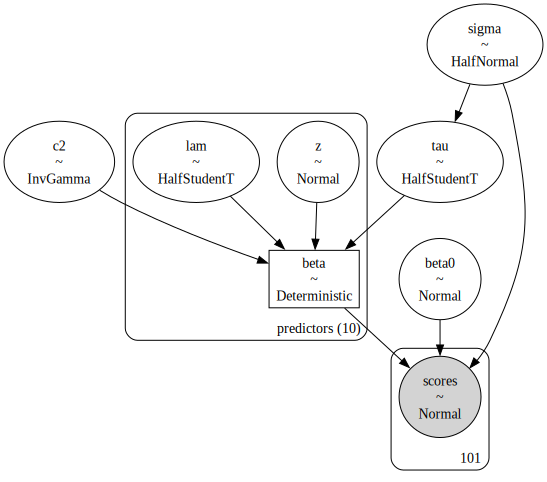

In [28]:
pm.model_to_graphviz(testScoreMds)

### Sample chains

In [29]:
with testScoreMds:
    prior_samples = pm.sample_prior_predictive(100)

Sampling: [beta0, c2, lam, scores, sigma, tau, z]


### Ploting results

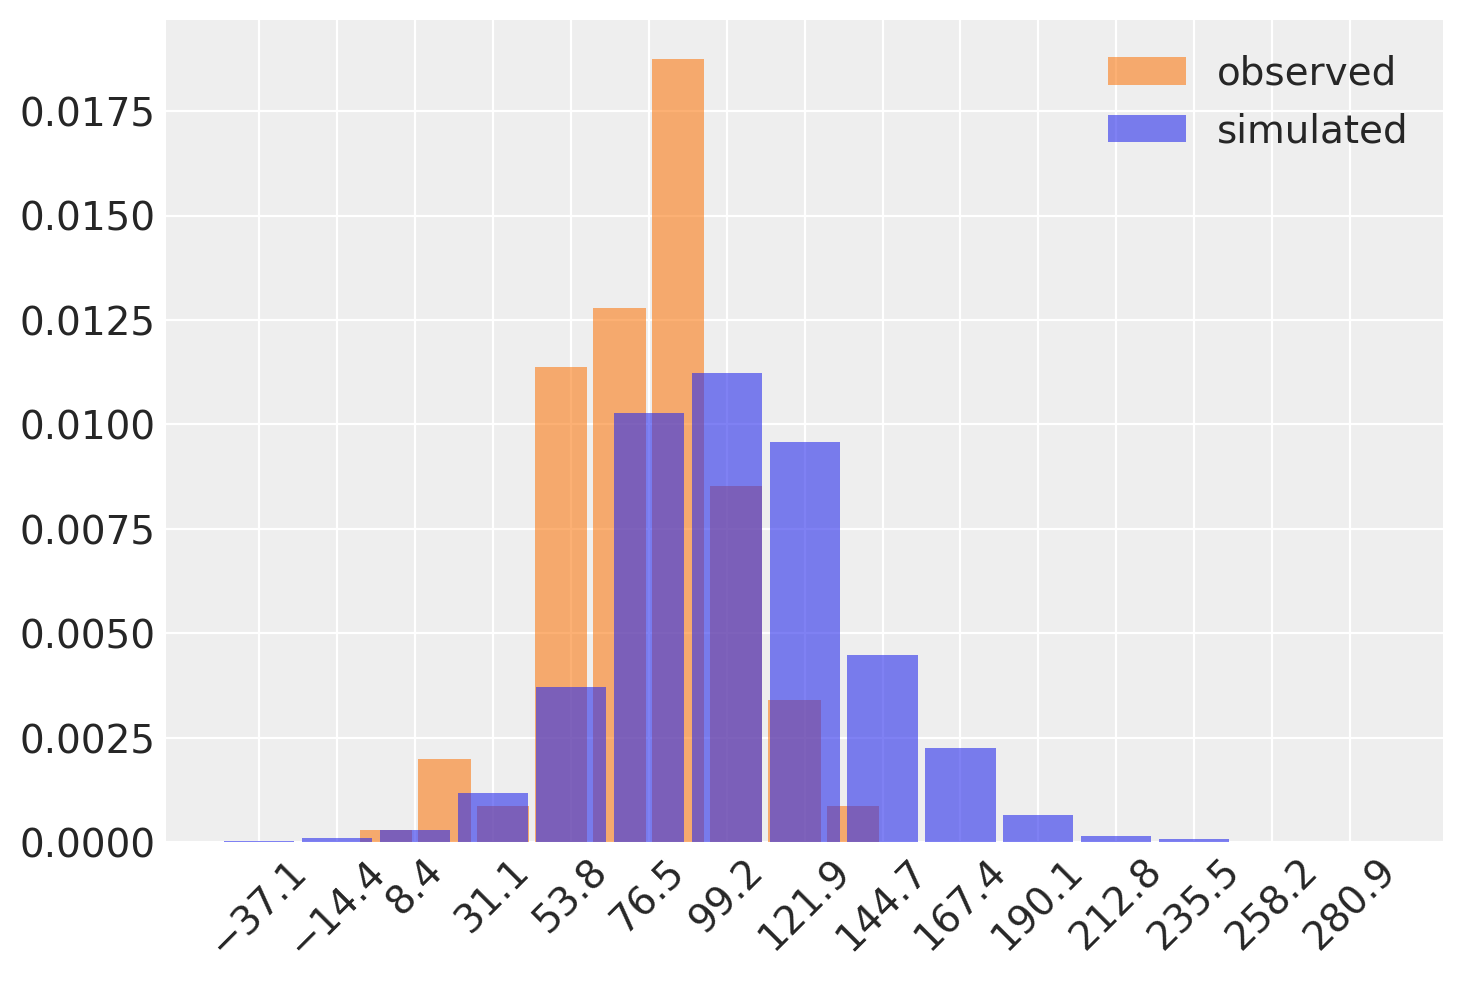

In [31]:
az.plot_dist(
    testScores["score"].values,
    kind="hist",
    color="C1",
    hist_kwargs=dict(alpha=0.6),
    label="observed",
)
az.plot_dist(
    prior_samples.prior_predictive["scores"],
    kind="hist",
    hist_kwargs=dict(alpha=0.6),
    label="simulated",
)
plt.xticks(rotation=45);

### More samples

In [33]:
with testScoreMds:
    idata = pm.sample(1000, tune = 2000, random_seed = 42, target_accept = 0.99)

C:\Users\bacos1\.conda\envs\pymc_env\Lib\site-packages\pytensor\tensor\elemwise.py:782: RuntimeWarning: divide by zero encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\bacos1\.conda\envs\pymc_env\Lib\site-packages\pytensor\tensor\elemwise.py:782: RuntimeWarning: divide by zero encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\bacos1\.conda\envs\pymc_env\Lib\site-packages\pytensor\tensor\elemwise.py:782: RuntimeWarning: divide by zero encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\bacos1\.conda\envs\pymc_env\Lib\site-packages\pytensor\tensor\elemwise.py:782: RuntimeWarning: divide by zero encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\bacos1\.conda\envs\pymc_env\Lib\site-packages\pytensor\tensor\elemwise.py:782: RuntimeWarning: divide by zero encountered in divide
  variables = ufunc(*uf

C:\Users\bacos1\.conda\envs\pymc_env\Lib\site-packages\pytensor\tensor\elemwise.py:782: RuntimeWarning: divide by zero encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\bacos1\.conda\envs\pymc_env\Lib\site-packages\pytensor\tensor\elemwise.py:782: RuntimeWarning: divide by zero encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\bacos1\.conda\envs\pymc_env\Lib\site-packages\pytensor\tensor\elemwise.py:782: RuntimeWarning: divide by zero encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\bacos1\.conda\envs\pymc_env\Lib\site-packages\pytensor\tensor\elemwise.py:782: RuntimeWarning: divide by zero encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\bacos1\.conda\envs\pymc_env\Lib\site-packages\pytensor\tensor\elemwise.py:782: RuntimeWarning: divide by zero encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\bacos1\.conda\envs\pymc_env\Lib\site-pack

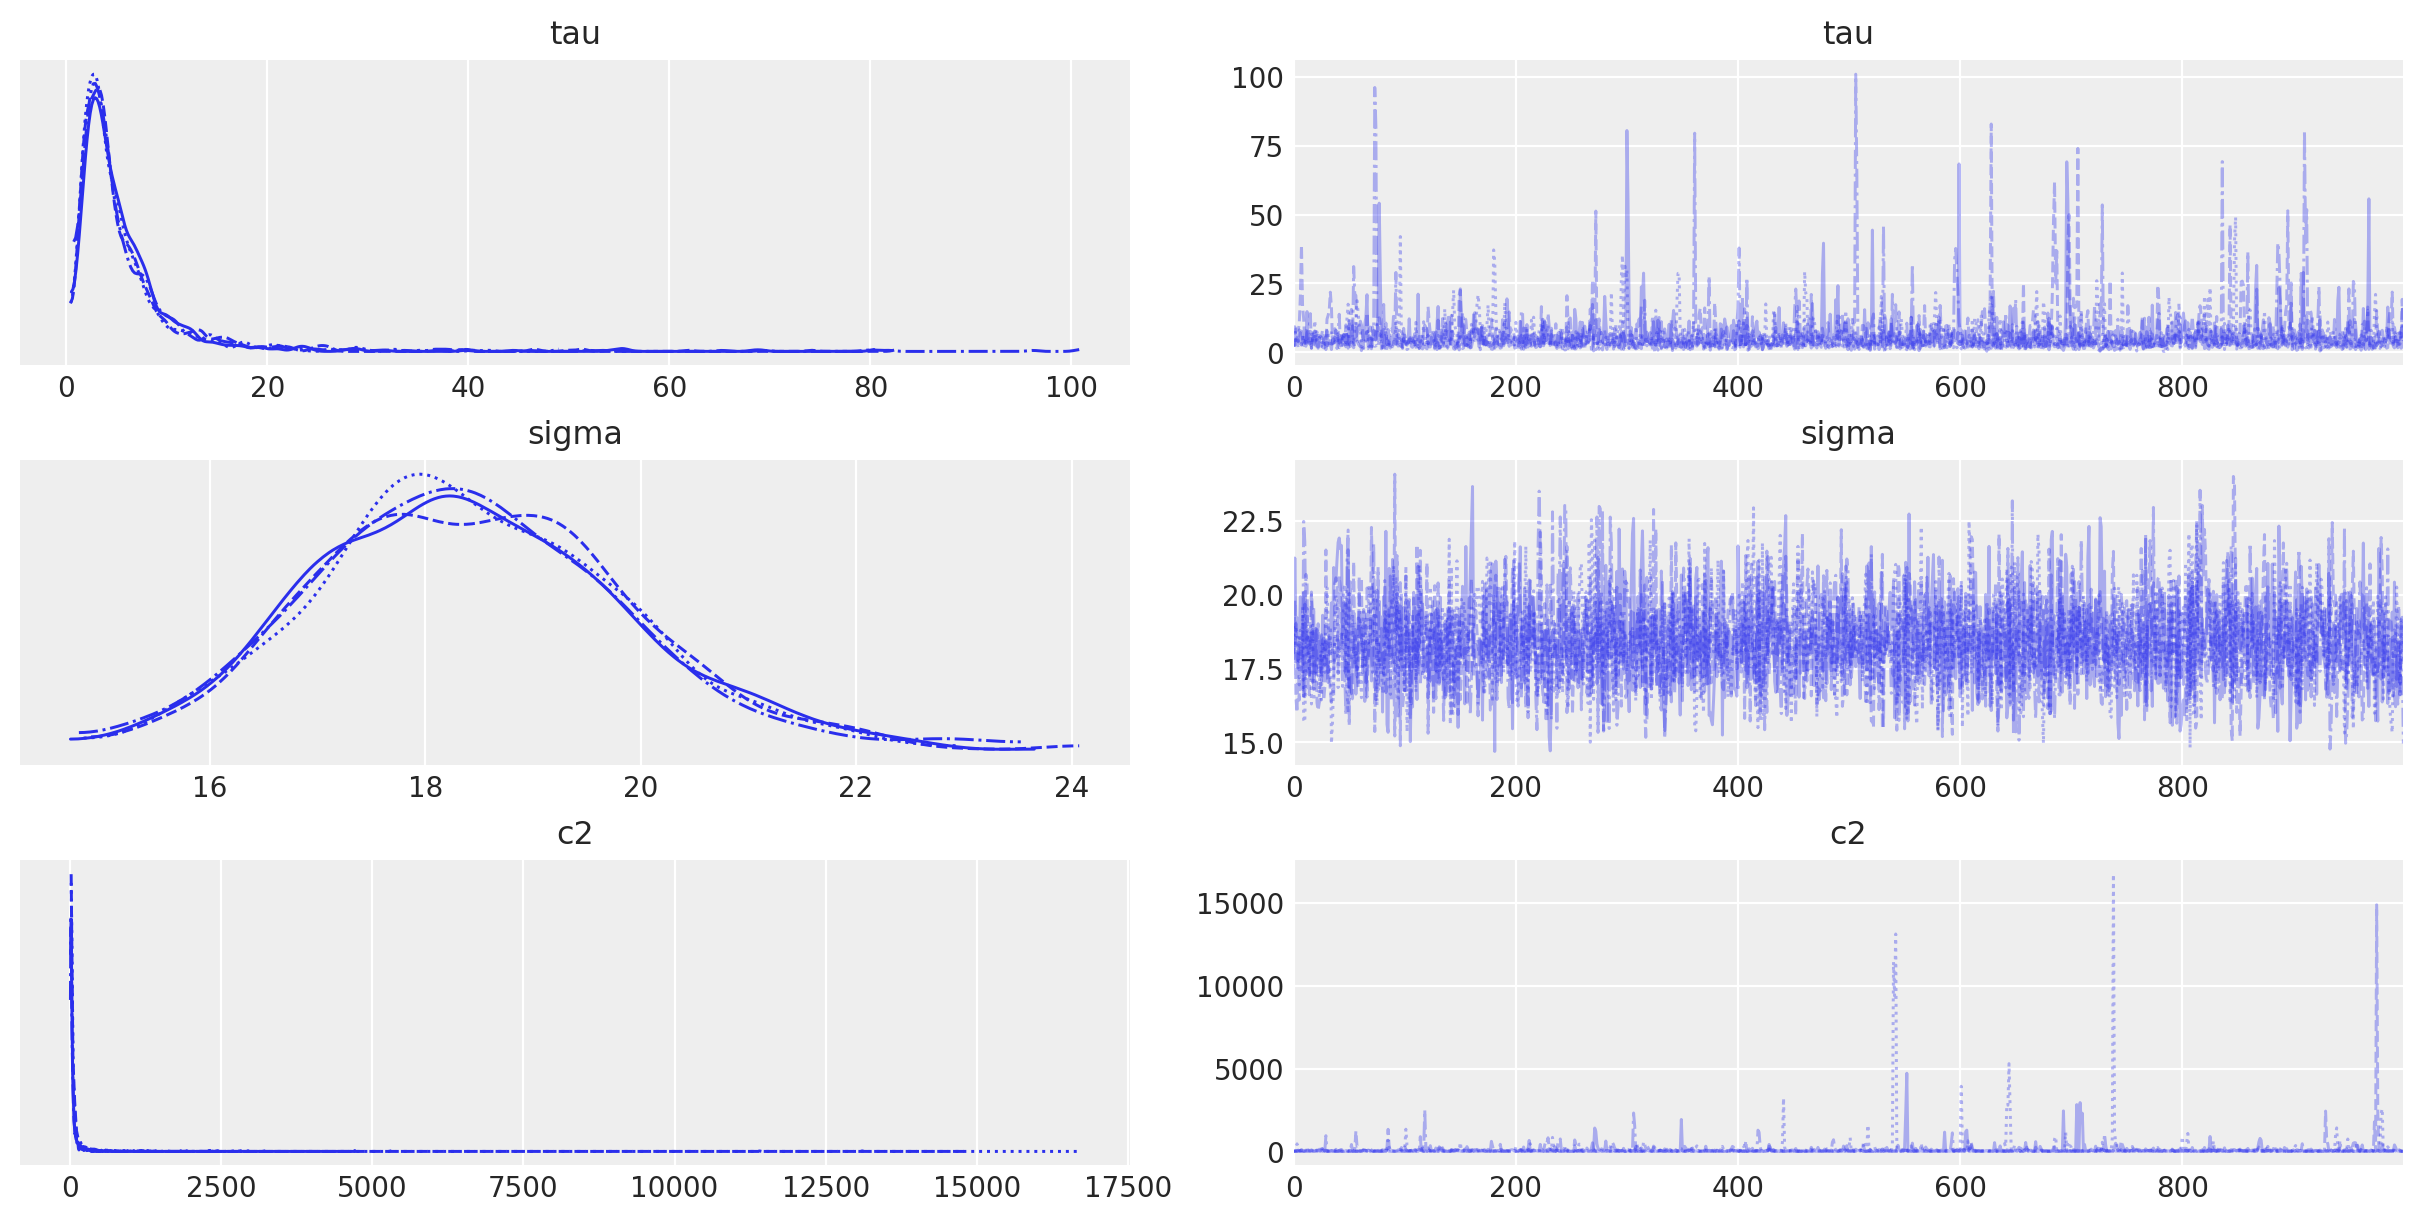

In [34]:
az.plot_trace(idata, var_names = ['tau', 'sigma', 'c2']);

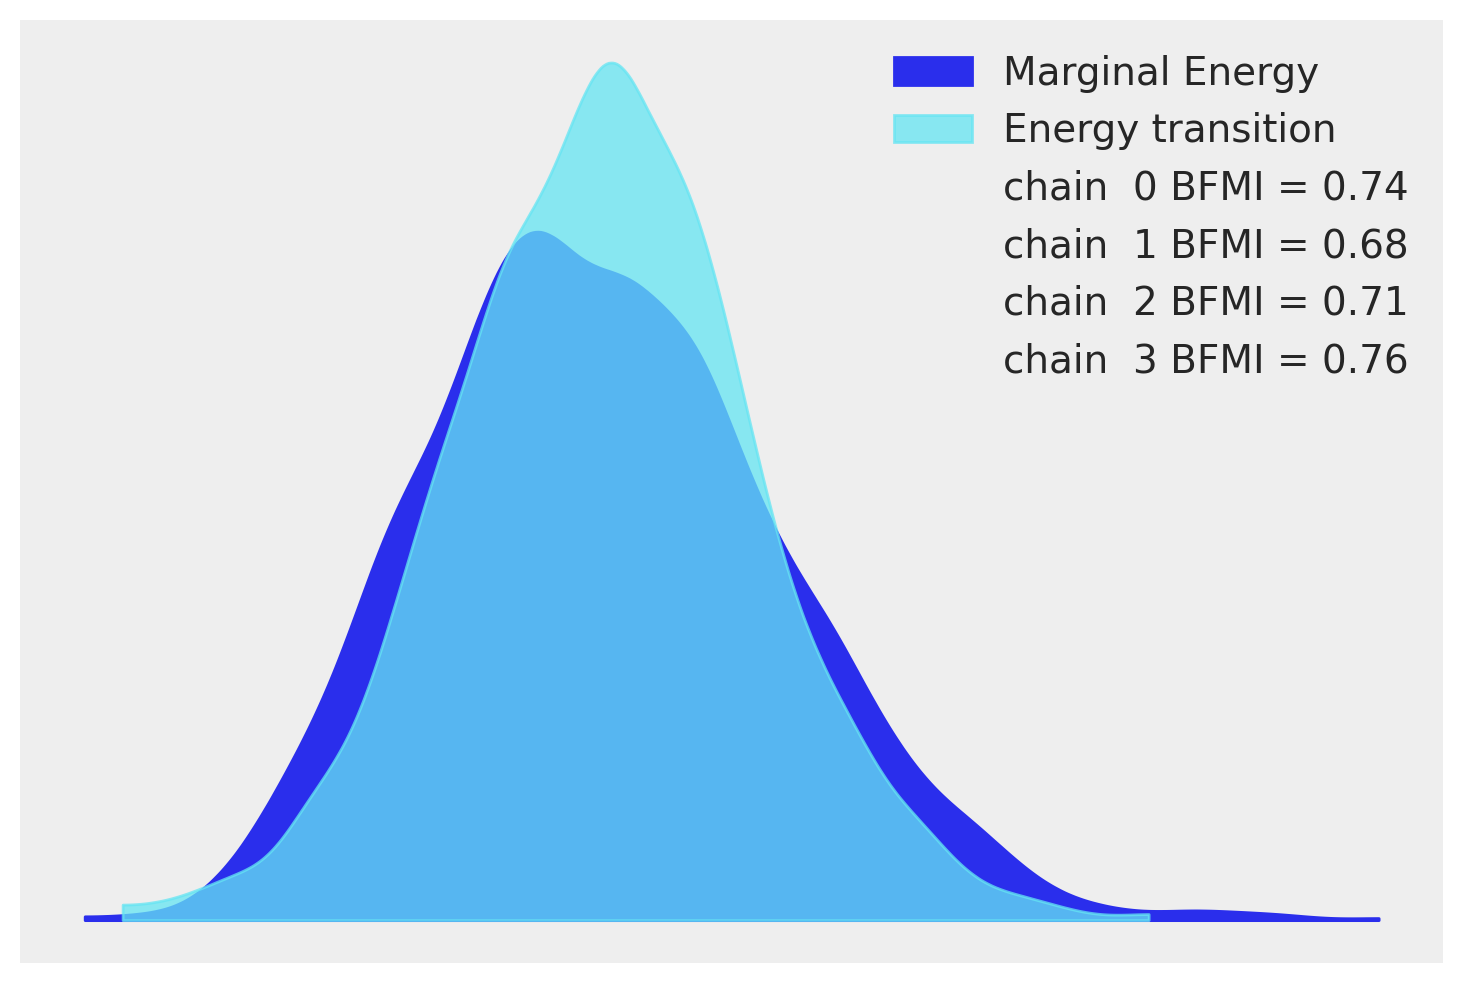

In [35]:
az.plot_energy(idata);

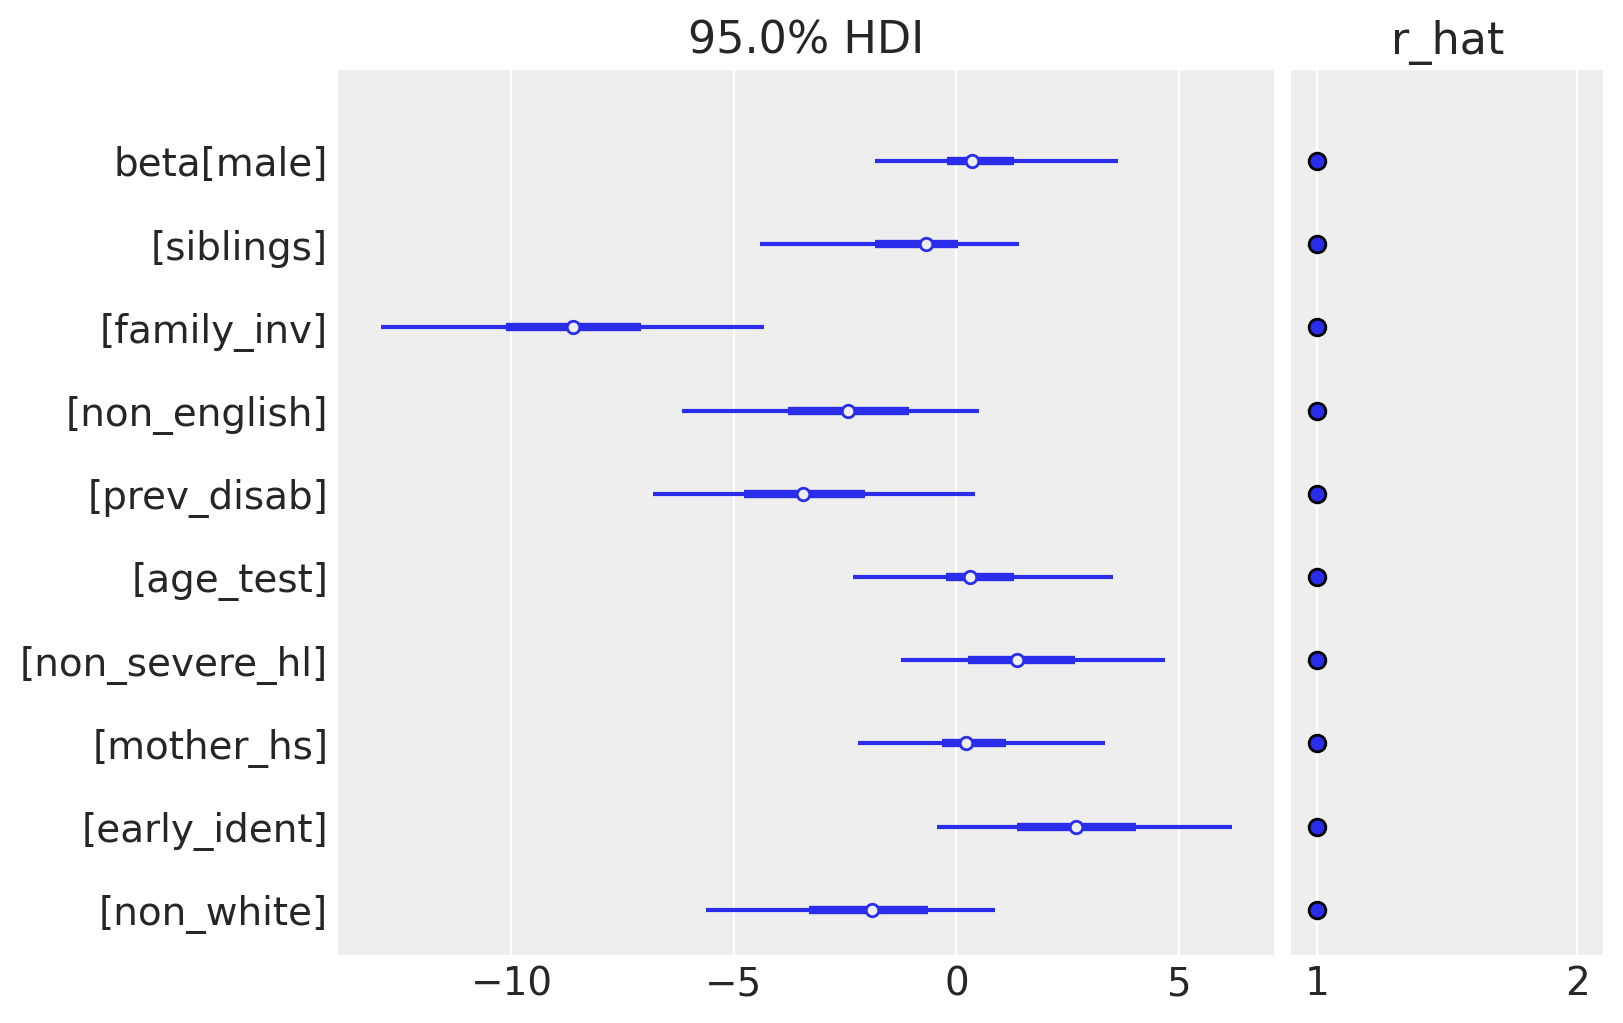

In [36]:
az.plot_forest(idata, var_names = ['beta'], combined = True, hdi_prob = 0.95, r_hat = True);

## Case study 2

### Load data

In [37]:
# fmt: off
disaster_data = pd.Series(
    [4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
    3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
    2, 2, 3, 4, 2, 1, 3, np.nan, 2, 1, 1, 1, 1, 3, 0, 0,
    1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
    0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
    3, 3, 1, np.nan, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
    0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1]
)

In [38]:
years = np.arange(1851, 1962)

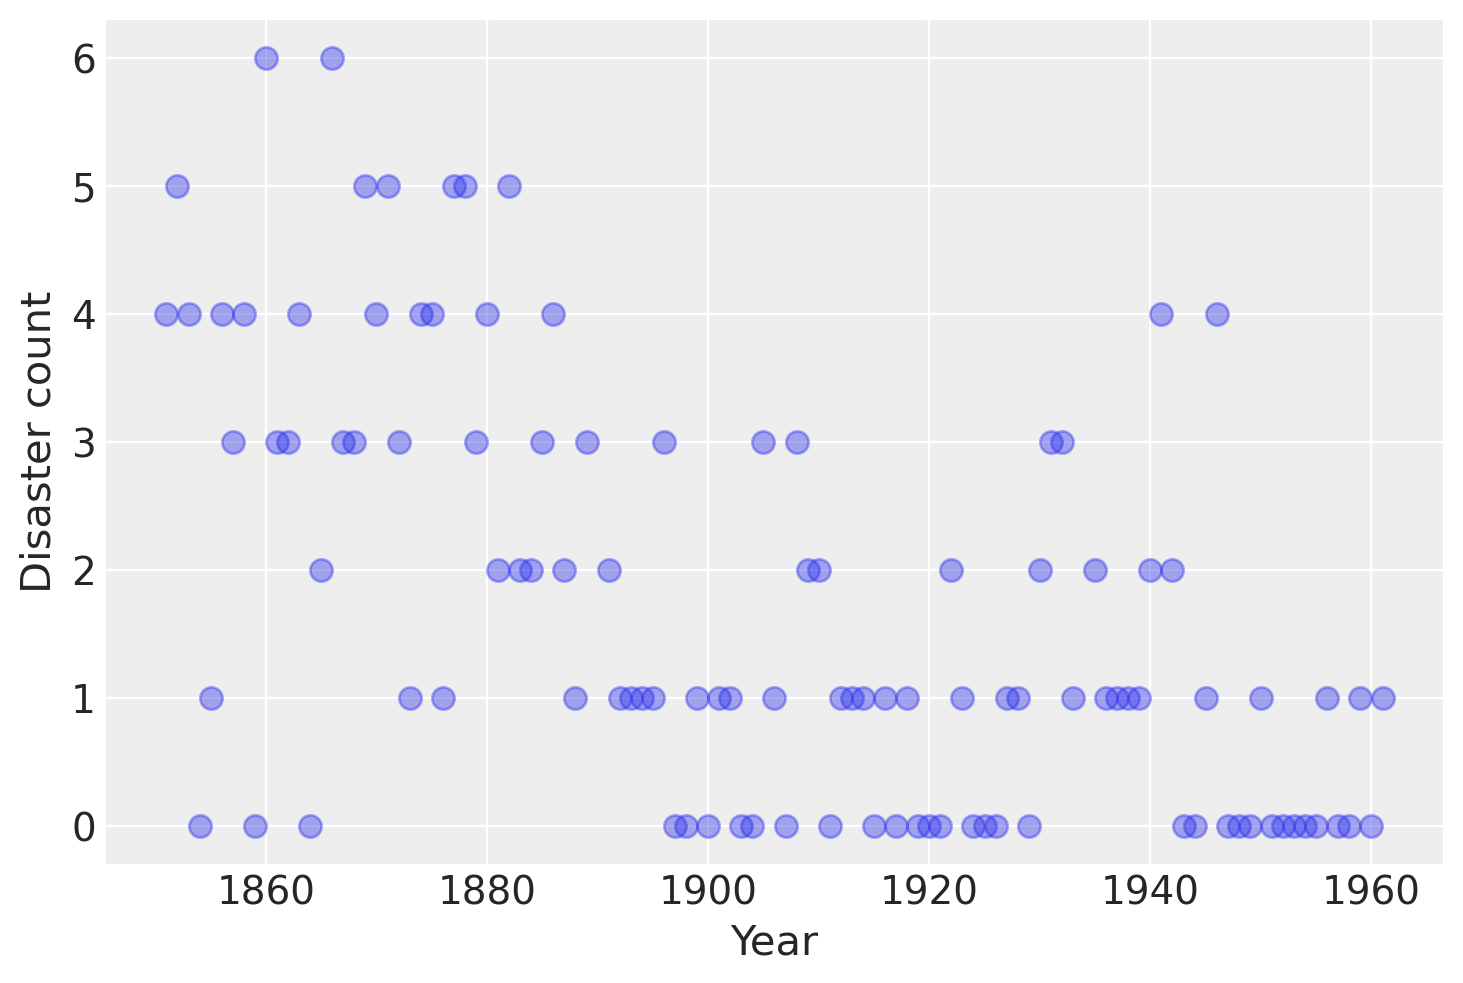

In [39]:
plt.plot(years, disaster_data, "o", markersize=8, alpha=0.4)
plt.ylabel("Disaster count")
plt.xlabel("Year");

### Model

In [42]:
with pm.Model() as disasterMdl:
    switchpoint = pm.DiscreteUniform('switchpoint', lower = years.min(), upper = years.max())
    
    # Priors for pre and post switch rates number of disasters
    early_rate = pm.Exponential('early_rate', 1.0)
    late_rate = pm.Exponential('late_rate', 1.0)
    
    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= years, early_rate, late_rate)
    
    # Model
    disasters = pm.Poisson('disasters', rate, observed = disaster_data)

C:\Users\bacos1\.conda\envs\pymc_env\Lib\site-packages\pymc\model.py:1340: RuntimeWarning: invalid value encountered in cast
  data = convert_observed_data(data).astype(rv_var.dtype)
C:\Users\bacos1\.conda\envs\pymc_env\Lib\site-packages\pymc\model.py:1363: ImputationWarning: Data in disasters contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


In [43]:
with disasterMdl:
    idata = pm.sample(10000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [switchpoint]
>>Metropolis: [disasters_unobserved]
>NUTS: [early_rate, late_rate]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 905 seconds.


### Plot results

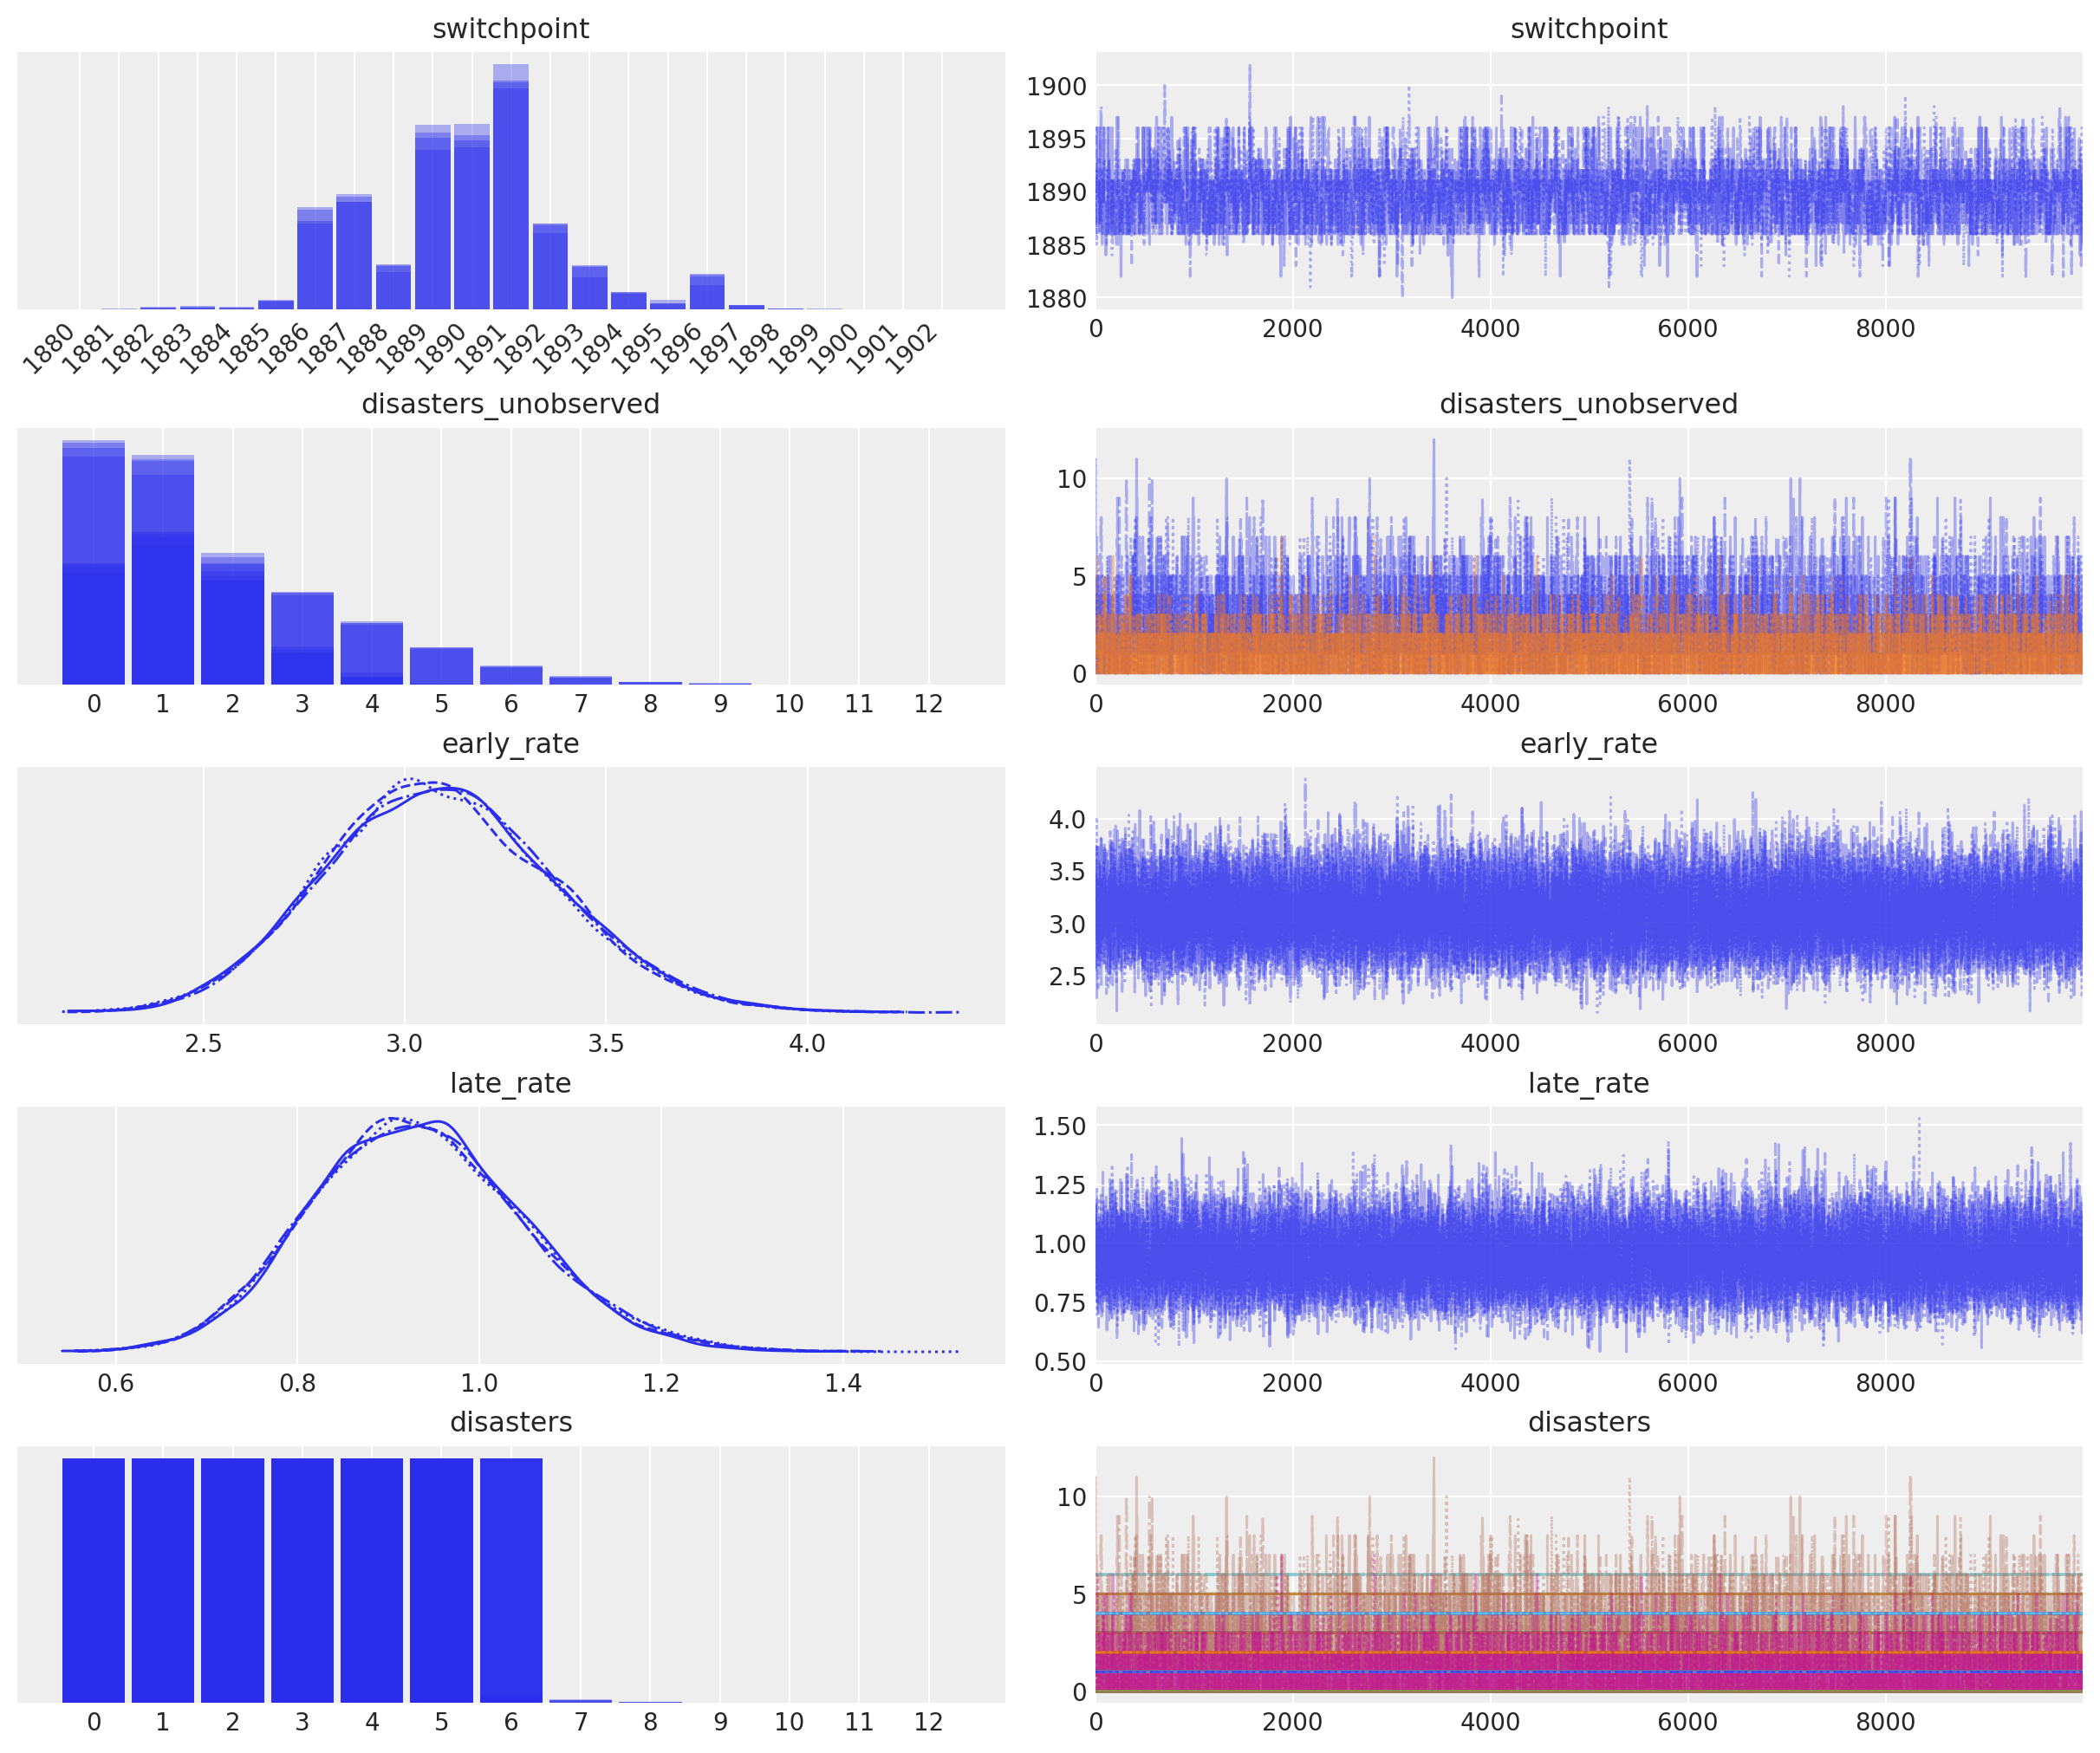

In [44]:
axes_arr = az.plot_trace(idata)
plt.draw()
for ax in axes_arr.flatten():
    if ax.get_title() == "switchpoint":
        labels = [label.get_text() for label in ax.get_xticklabels()]
        ax.set_xticklabels(labels, rotation=45, ha="right")
        break
plt.draw()

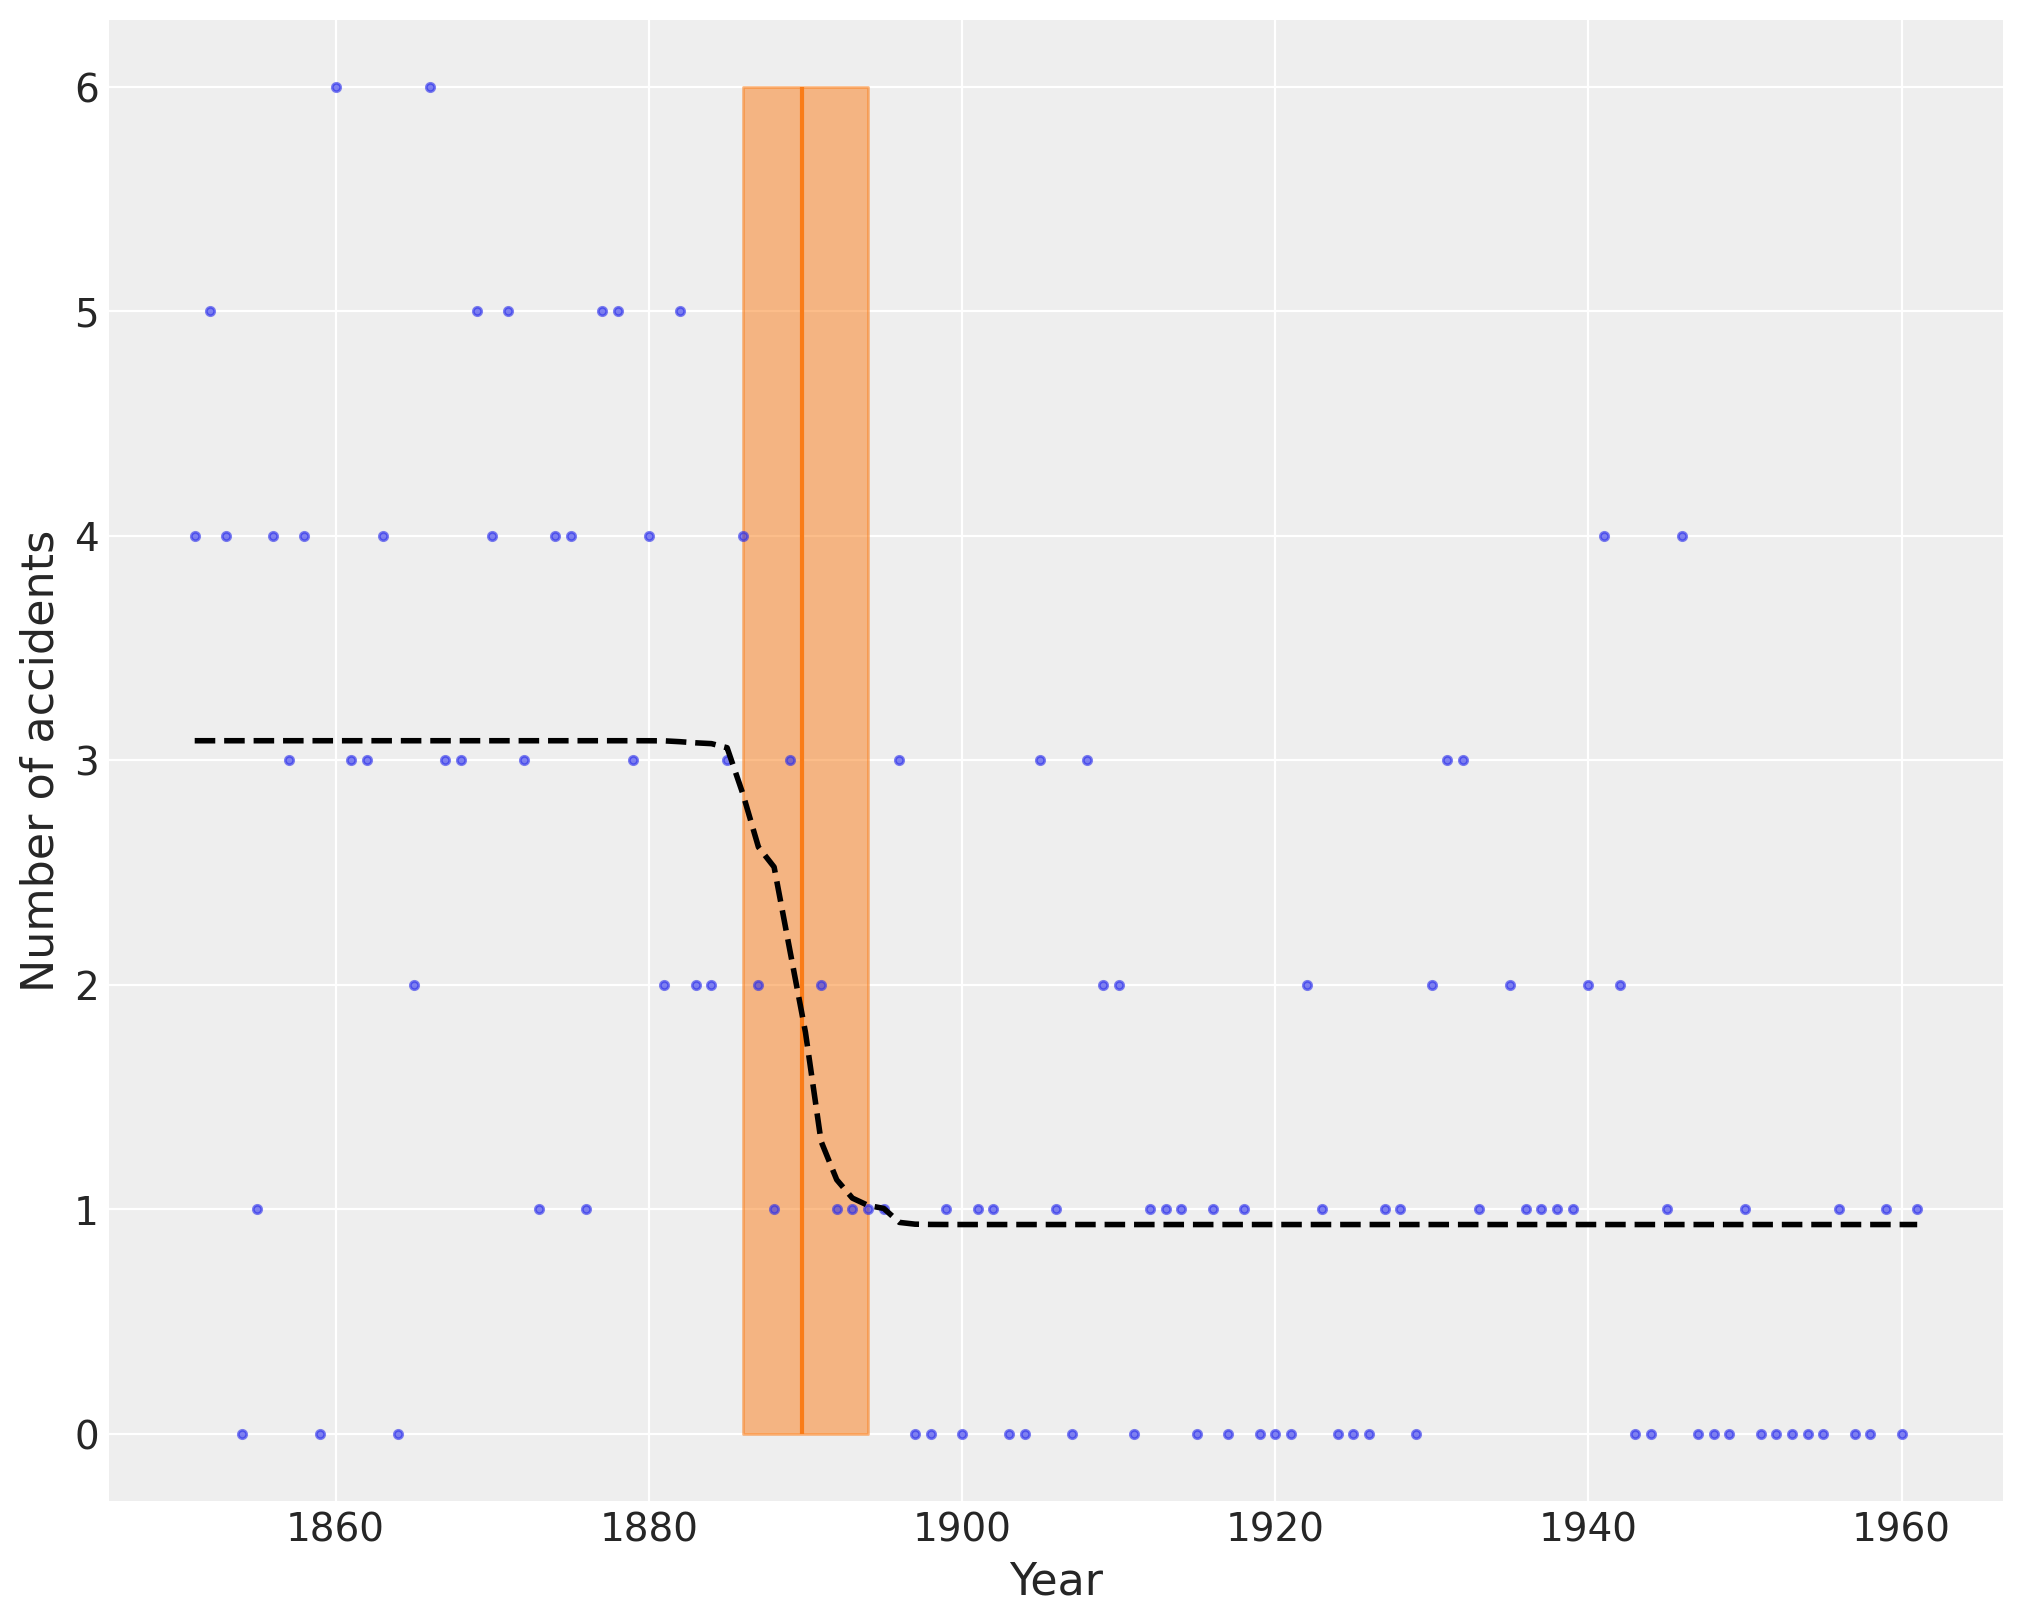

In [45]:
plt.figure(figsize=(10, 8))
plt.plot(years, disaster_data, ".", alpha=0.6)
plt.ylabel("Number of accidents", fontsize=16)
plt.xlabel("Year", fontsize=16)

trace = idata.posterior.stack(draws=("chain", "draw"))

plt.vlines(trace["switchpoint"].mean(), disaster_data.min(), disaster_data.max(), color="C1")
average_disasters = np.zeros_like(disaster_data, dtype="float")
for i, year in enumerate(years):
    idx = year < trace["switchpoint"]
    average_disasters[i] = np.mean(np.where(idx, trace["early_rate"], trace["late_rate"]))

sp_hpd = az.hdi(idata, var_names=["switchpoint"])["switchpoint"].values
plt.fill_betweenx(
    y=[disaster_data.min(), disaster_data.max()],
    x1=sp_hpd[0],
    x2=sp_hpd[1],
    alpha=0.5,
    color="C1",
)
plt.plot(years, average_disasters, "k--", lw=2);